# FCA

Technical Challenge for Data Science Candidates

This workbook loads a pickle file from the prior notebook.

Visualisation

In [159]:
import numpy as np
import pandas as pd
import math
import json

from os import path

import scipy.stats as st
import statsmodels as sm
import statsmodels.api as smi

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn import metrics 

from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns

pd.__version__

'0.24.2'

In [160]:
# If you turn this feature on, you can display each result as it happens.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [161]:
# this is the local Utility module and it reloaded each time.
from fca import Utility

In [162]:
%load_ext autoreload
%autoreload 1
%aimport fca

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
# My utility singleton.
i0 = Utility.instance()

## Visualisations

There is a lot of data, take a sample.

In [164]:
df2 = pd.read_pickle("catted.pickle")
df2 = pd.read_pickle("coded.pickle")
df2 = pd.read_pickle("scaled.pickle")

y = df2.y

In [165]:
## Remove the columns with 0 for correlations
cols = list(X.columns)
cols1 = list(filter(lambda x: x.endswith('0'), cols))
cols2 = set(cols).difference(cols1)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=0.2)

In [167]:
# Default case is take a small sample

X = X_test[cols2]
y = y_test

In [168]:
# Another variant is to check when the outcome is true (or false)
# This can trap conditioned outcomes
set(df2.y)
X = df2[df2.y > 0][cols2]
y = df2.y

{-0.3563093198329269, 2.8065502200978045}

In [169]:
X.head()
X.info()

,previous,contact,euribor3m,age,marital,day_of_week,nr.employed,pdays,default,emp.var.rate,...,y,poutcome,job,cons.conf.idx,education,housing,month,cons.price.idx,duration,loan
75,-0.349494,1.31827,0.71246,0.093650,-0.360309,-0.718834,0.33168,0.194144,-1.946613,0.648092,...,2.80655,-0.372802,-0.880230,0.886447,-1.578162,0.916174,0.762558,0.722722,5.078428,-0.319712
83,-0.349494,1.31827,0.71246,0.861322,0.763965,-0.718834,0.33168,0.194144,-1.946613,0.648092,...,2.80655,-0.372802,2.174285,0.886447,0.695924,0.916174,0.762558,0.722722,3.022704,-0.319712
88,-0.349494,1.31827,0.71246,0.861322,0.763965,-0.718834,0.33168,0.194144,0.513260,0.648092,...,2.80655,-0.372802,-0.007511,0.886447,-0.441119,-0.915462,0.762558,0.722722,4.661884,-0.319712
129,-0.349494,1.31827,0.71246,0.093650,0.763965,-0.718834,0.33168,0.194144,-1.946613,0.648092,...,2.80655,-0.372802,-0.007511,0.886447,1.264445,0.916174,0.762558,0.722722,1.236963,-0.319712
139,-0.349494,1.31827,0.71246,0.477486,0.763965,-0.718834,0.33168,0.194144,-1.946613,0.648092,...,2.80655,-0.372802,-0.880230,0.886447,-0.441119,0.916174,0.762558,0.722722,0.781850,-0.319712


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4640 entries, 75 to 41186
Data columns (total 21 columns):
previous          4640 non-null float64
contact           4640 non-null float64
euribor3m         4640 non-null float64
age               4640 non-null float64
marital           4640 non-null float64
day_of_week       4640 non-null float64
nr.employed       4640 non-null float64
pdays             4640 non-null float64
default           4640 non-null float64
emp.var.rate      4640 non-null float64
campaign          4640 non-null float64
y                 4640 non-null float64
poutcome          4640 non-null float64
job               4640 non-null float64
cons.conf.idx     4640 non-null float64
education         4640 non-null float64
housing           4640 non-null float64
month             4640 non-null float64
cons.price.idx    4640 non-null float64
duration          4640 non-null float64
loan              4640 non-null float64
dtypes: float64(21)
memory usage: 797.5 KB


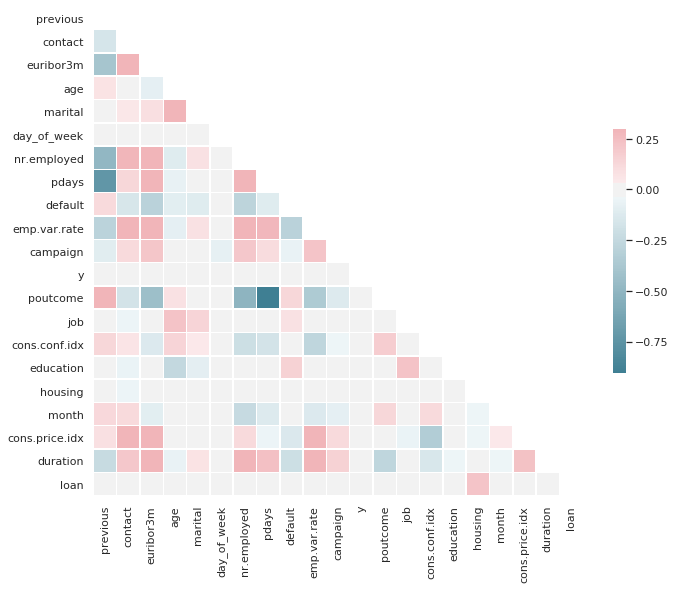

In [170]:
## Correlations

sns.set(style="white")

# Compute the correlation matrix
# Put the output back in
X1 = X.copy()
X1['y'] = y
corr = X1.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

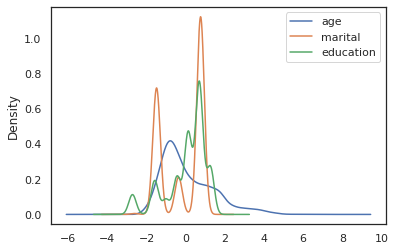

In [171]:
# Check the age shape

X[['age', 'marital', 'education']].plot.density()

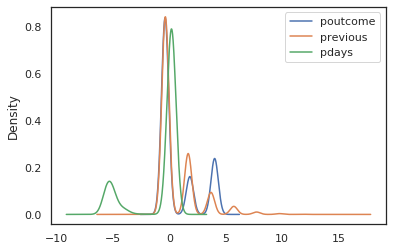

In [176]:
# These seem to lagged identical
X[['poutcome', 'previous', 'pdays']].plot.density()

### euribor3m cluster

These seem to be related.

Looking at these. It might be the future-value of the loan at the time the loanee applied. 
The most information would then be in the price

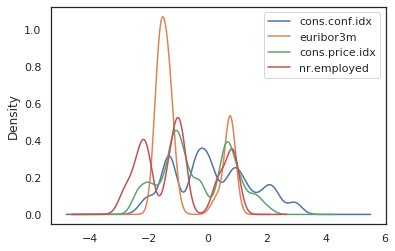

In [174]:
X[['cons.conf.idx', 'euribor3m', 'cons.price.idx', 'nr.employed']].plot.density()

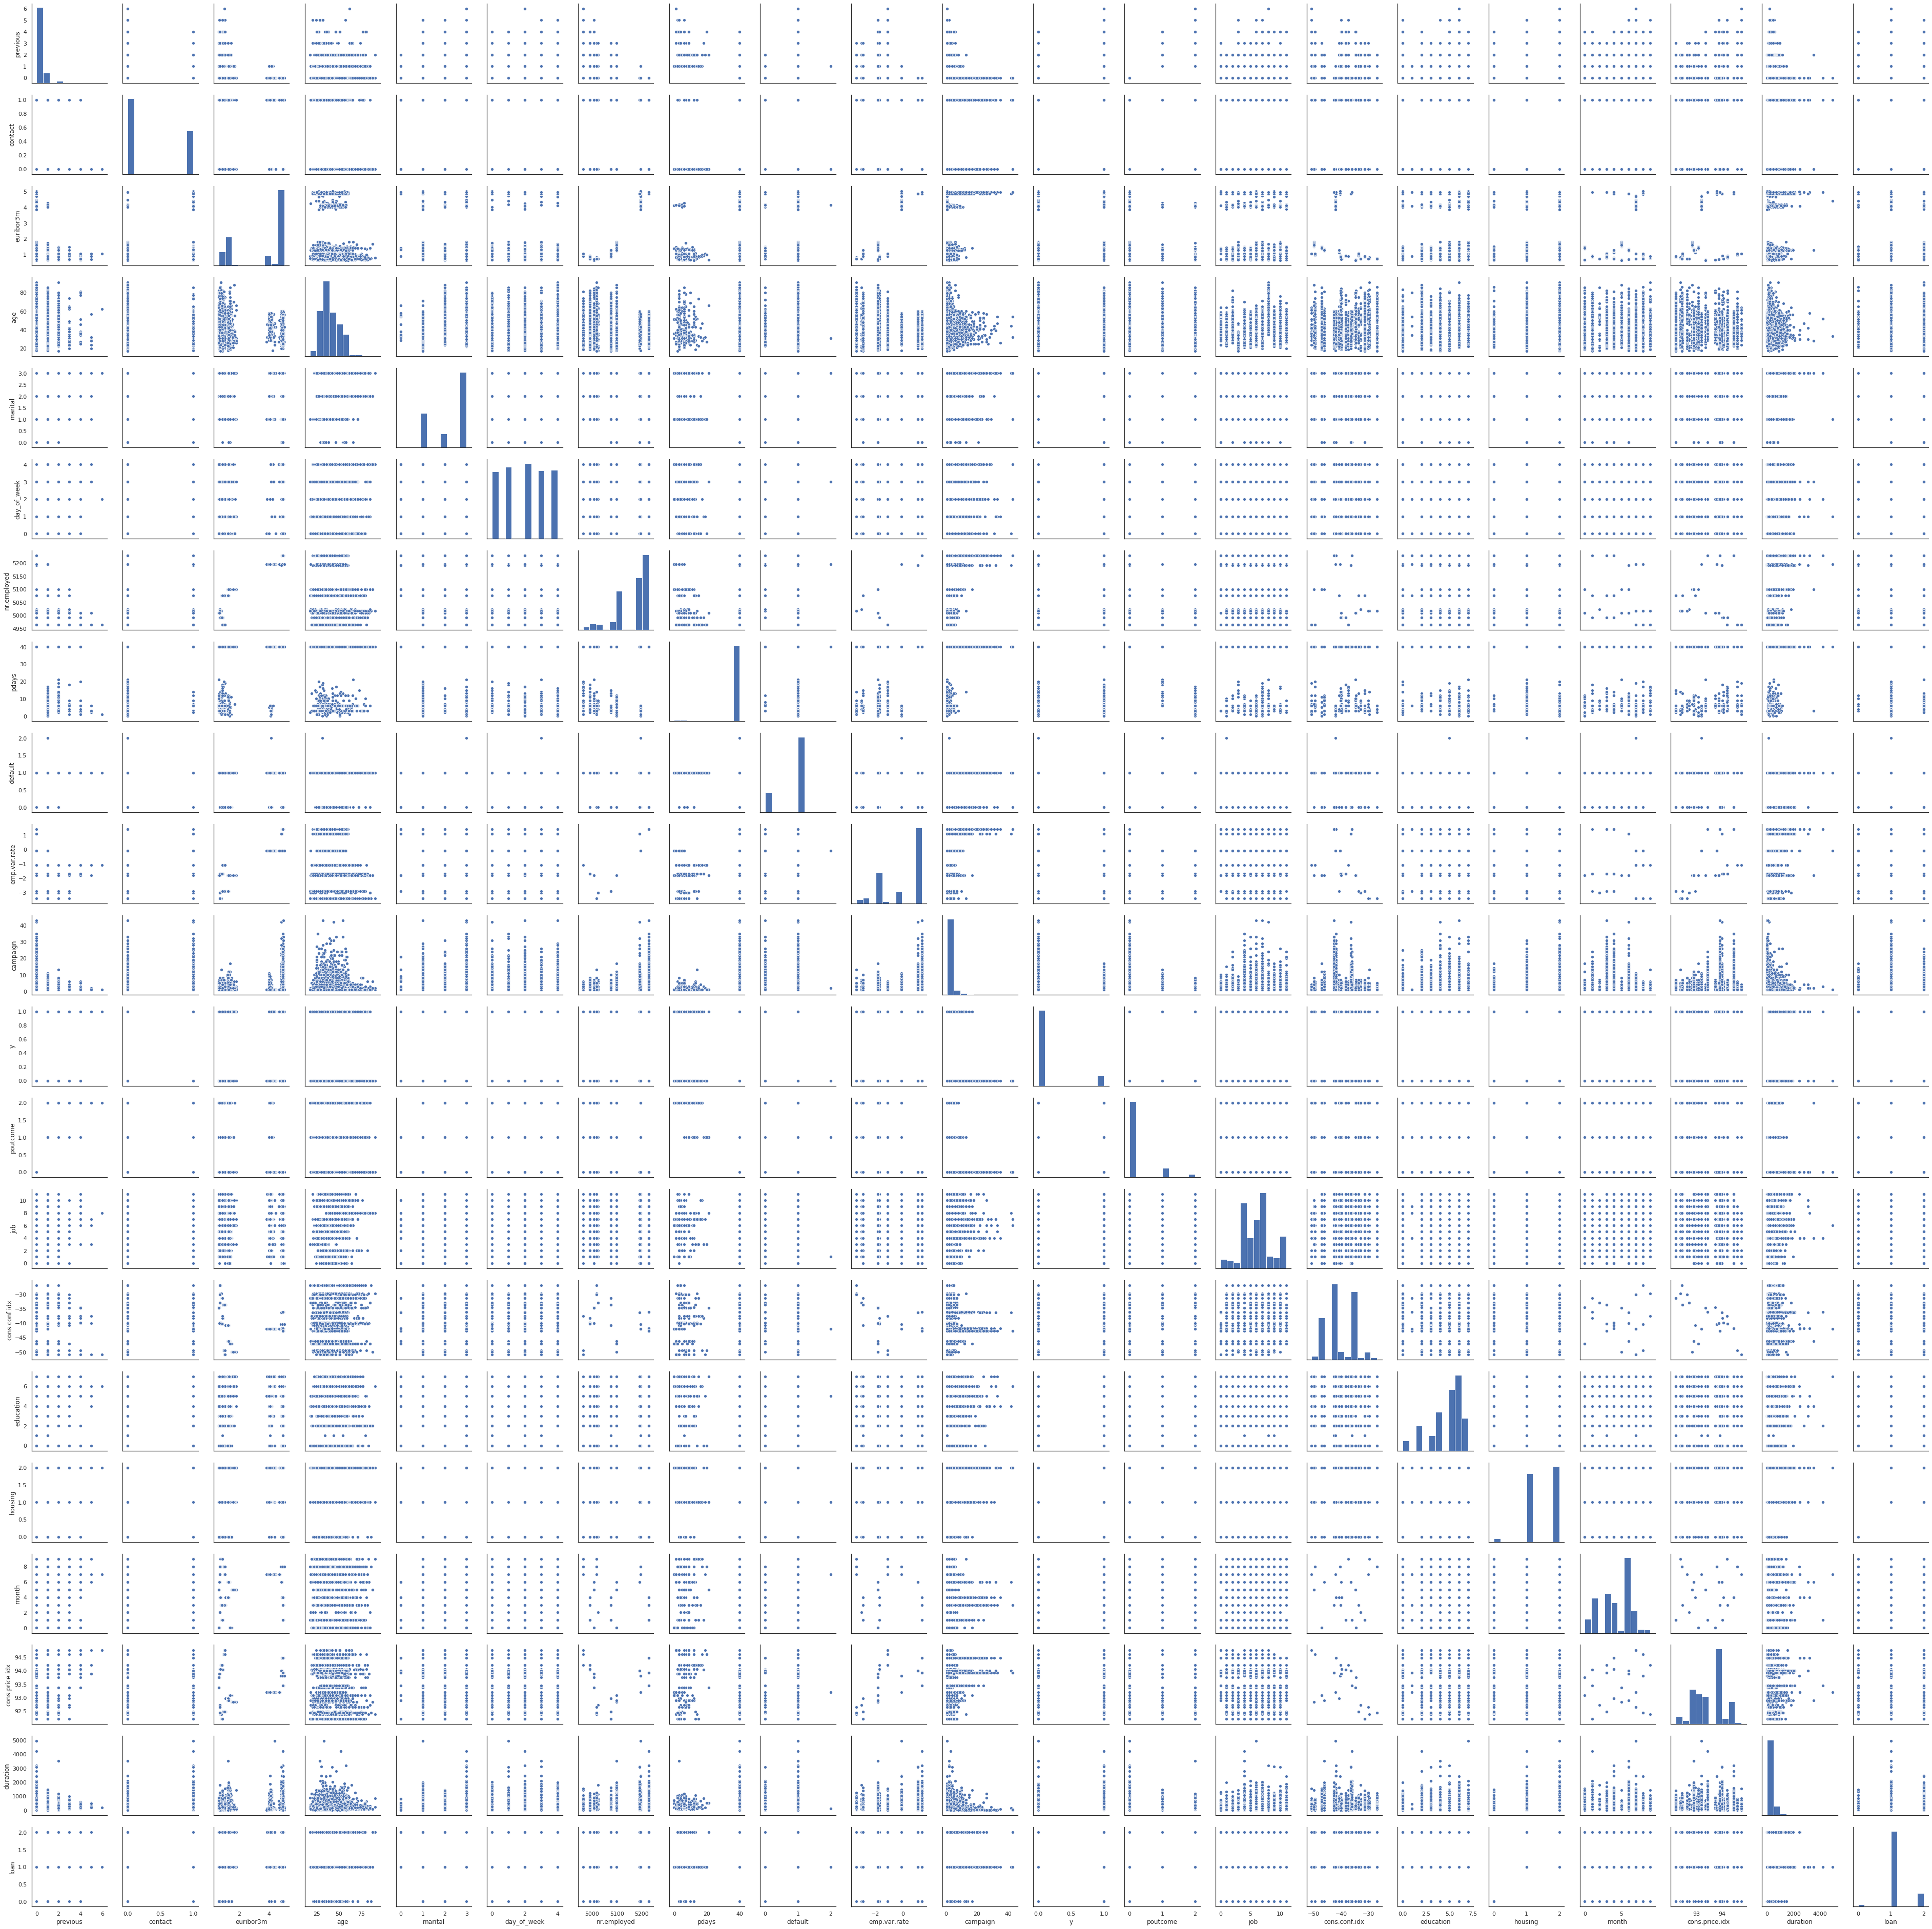

In [141]:
# A very time-consuming pair plot even on the sample

sns.pairplot(X)

In [31]:
df2['marital'];

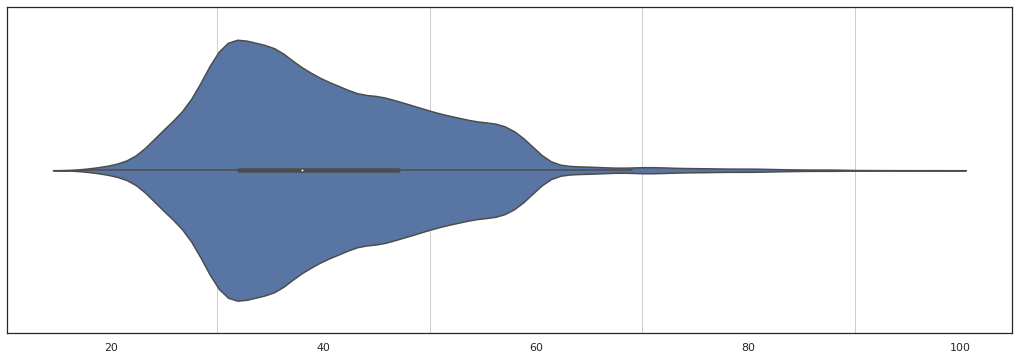

In [154]:
# Violin plot: age

from matplotlib.ticker import AutoMinorLocator

fig = plt.figure(figsize=(18,6))

ax1 = sns.violinplot(x=['age'], data=df2)

ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))

ax1.grid(which='minor', axis='x', linewidth=1)

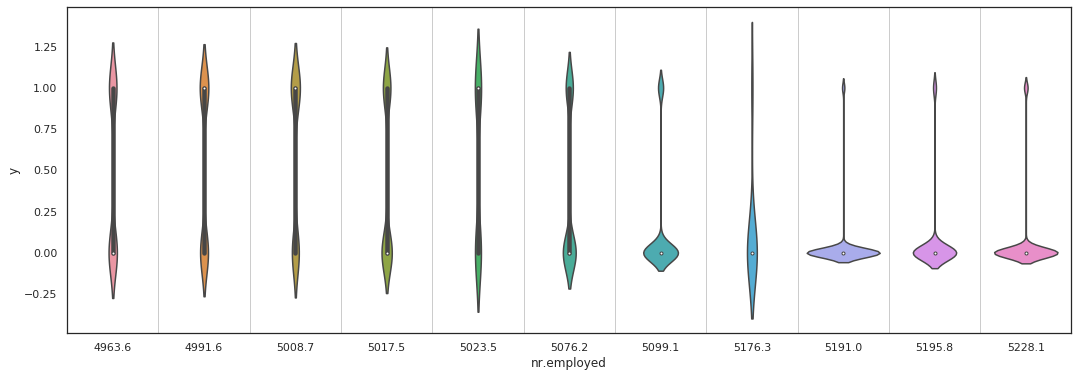

In [155]:
# Violin plot: n.employed

from matplotlib.ticker import AutoMinorLocator

fig = plt.figure(figsize=(18,6))

ax1 = sns.violinplot(x=df2['nr.employed'], y=df2['y'])

ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))

ax1.grid(which='minor', axis='x', linewidth=1)

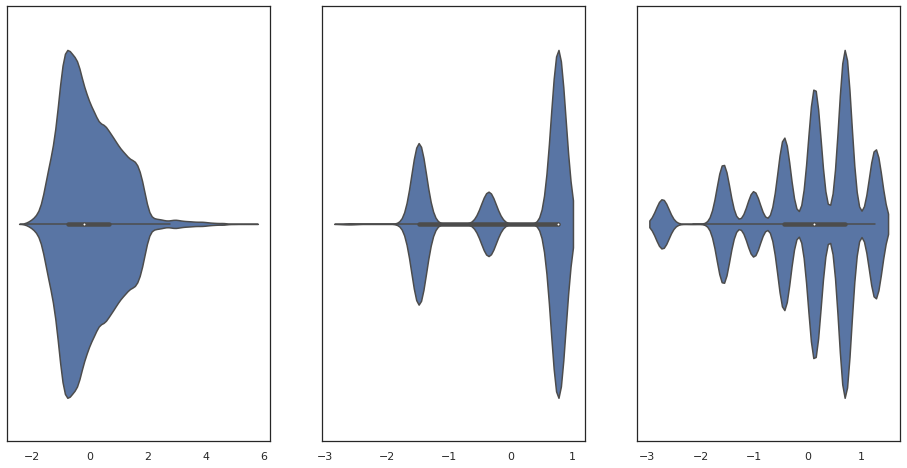

In [126]:
fig, axs = plt.subplots(figsize=(16,8), ncols=3)

sns.violinplot(x=['age'], data=df2, ax=axs[0])
sns.violinplot(x=['marital'], data=df2, ax=axs[1])
sns.violinplot(x=['education'], data=df2, ax=axs[2])